In [1]:
%load_ext autoreload  
%autoreload 2  

In [2]:
import numpy as np

import matplotlib.pyplot as plt  # fit_and_report zaten plotluyor ama lazım olabilir

from ocpy.oc import Linear, Quadratic, Keplerian, Parameter
from ocpy.oc_pymc import OCPyMC

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [linear1_a, linear1_b]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 27 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


array([[<Axes: >, None],
       [<Axes: xlabel='linear1_a', ylabel='linear1_b'>, <Axes: >]],
      dtype=object)

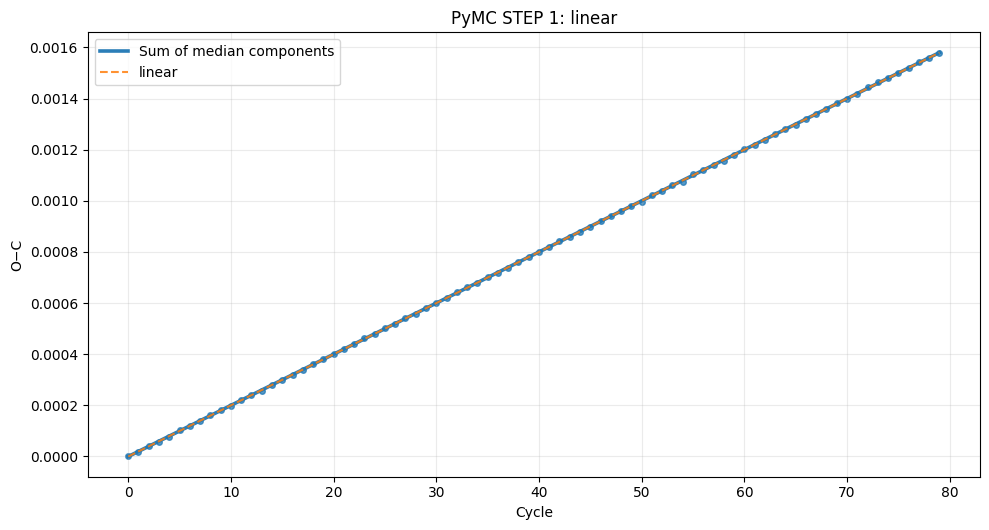

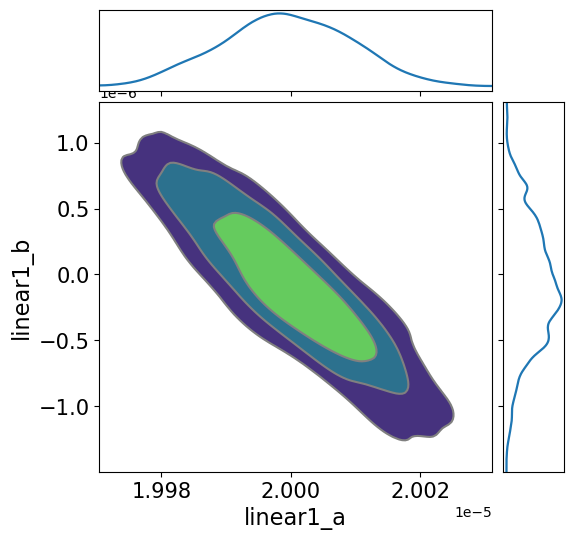

In [3]:

# ============================================================
# STEP 1: sadece lineer veri → fit_linear + corner
# ============================================================
cycle1 = np.arange(0, 80, 1.0)
true_a = 2e-5
oc1 = true_a * cycle1 + np.random.normal(0, 2e-6, size=cycle1.size)

oc_pm1 = OCPyMC(
    minimum_time=cycle1.tolist(),
    minimum_time_error=(np.ones_like(cycle1) * 2e-6).tolist(),
    cycle=cycle1.tolist(),
    oc=oc1.tolist(),
)

idata1 = oc_pm1.fit_linear(
    draws=1000,
    tune=1000,
    chains=2,
    target_accept=0.9,
    progressbar=True,
)

oc_pm1.fit_and_report(idata1, title="PyMC STEP 1: linear")

# posterior’u köşegen şeklinde göster
oc_pm1.create_corner_plot(
    idata1,
    method="arviz",   # senin fonksiyonda varsa
    kind="kde",
    figsize=(6, 6),
)

Initializing NUTS using jitter+adapt_diag...
c:\Users\Bar1\anaconda3\envs\ocpy\Lib\site-packages\pytensor\link\c\cmodule.py:2986: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [quadratic1_q]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 19 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


['quadratic1_q', 'y_model']


<Axes: title={'center': 'quadratic1_q'}>

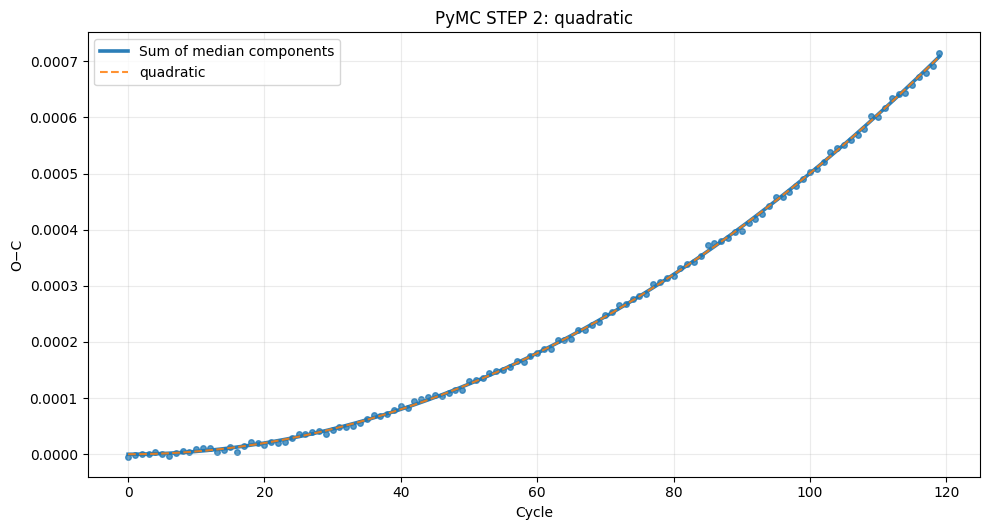

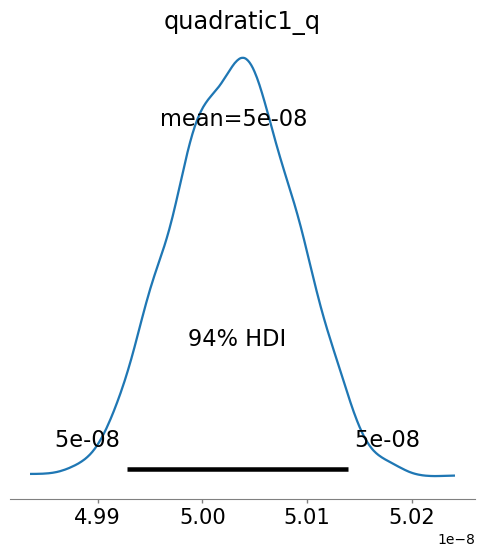

In [4]:
# STEP 2: sadece quadratic veri → fit + corner
cycle2 = np.arange(0, 120, 1.0)
true_q = 5e-8
oc2 = true_q * cycle2**2 + np.random.normal(0, 4e-6, size=cycle2.size)

oc_pm2 = OCPyMC(
    minimum_time=cycle2.tolist(),
    minimum_time_error=(np.ones_like(cycle2) * 4e-6).tolist(),
    cycle=cycle2.tolist(),
    oc=oc2.tolist(),
)

quad_comp = Quadratic(q=Parameter(value=1e-8, min=-1e-5, max=1e-5))
idata2 = oc_pm2.fit(
    [quad_comp],
    draws=1000,
    tune=1000,
    chains=2,
    target_accept=0.9,
    progressbar=True,
)

oc_pm2.fit_and_report(idata2, title="PyMC STEP 2: quadratic")

# hangi isimle çıktı diye bir bakalım
print(list(idata2.posterior.data_vars))

# tek parametre olduğu için corner yöntemiyle çiz
oc_pm2.create_corner_plot(
    idata2,
    method="corner",          # <--- burası önemli
    var_names=["quadratic_q"],  # eğer çıktıda "quadratic1_q" yazıyorsa onu yaz
    figsize=(6, 6),
)

[autoreload of cutils_ext failed: Traceback (most recent call last):
  File "c:\Users\Bar1\anaconda3\envs\ocpy\Lib\site-packages\IPython\extensions\autoreload.py", line 325, in check
    superreload(m, reload, self.old_objects)
  File "c:\Users\Bar1\anaconda3\envs\ocpy\Lib\site-packages\IPython\extensions\autoreload.py", line 580, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "c:\Users\Bar1\anaconda3\envs\ocpy\Lib\importlib\__init__.py", line 168, in reload
    raise ModuleNotFoundError(f"spec not found for the module {name!r}", name=name)
ModuleNotFoundError: spec not found for the module 'cutils_ext'
]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [kep11_amp, kep11_P, kep11_T0]


Output()

Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


array([[<Axes: ylabel='kep11_amp'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='kep11_P'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='kep11_amp', ylabel='kep11_T0'>,
        <Axes: xlabel='kep11_P'>, <Axes: xlabel='kep11_T0'>]],
      dtype=object)

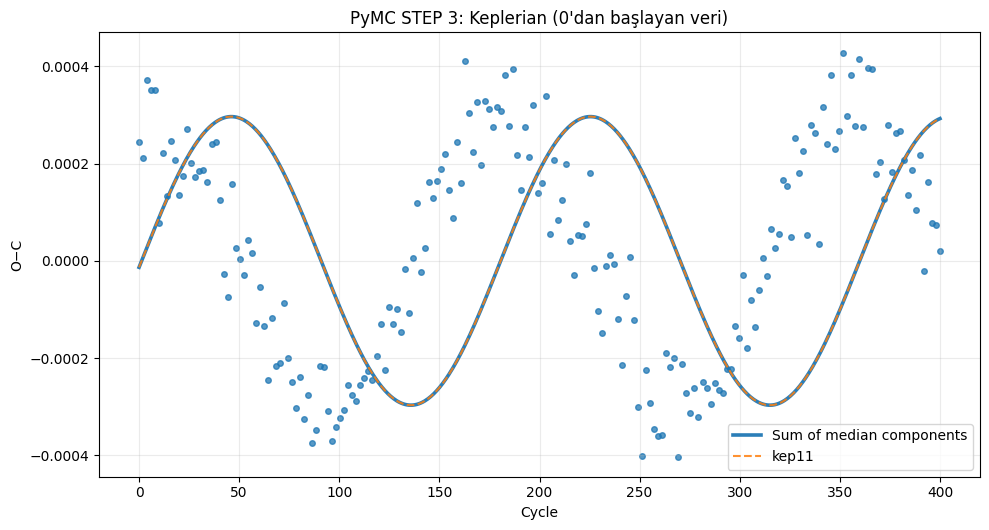

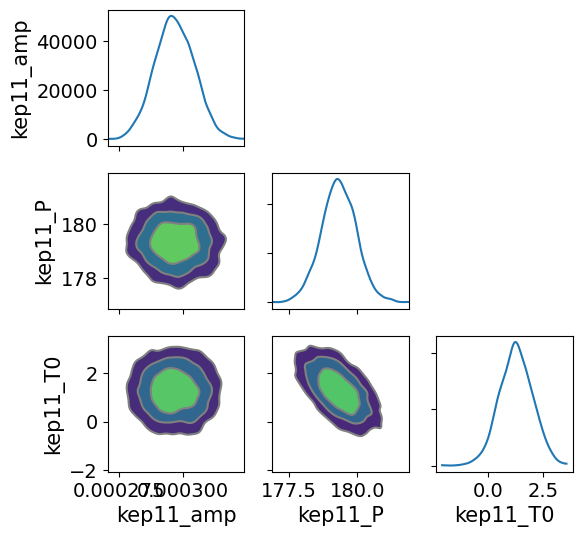

In [5]:
# ============================================================
# STEP 3: oc Keplerian verisi (0'dan başlar) → pymc fit_keplerian + corner
# ============================================================
import numpy as np

from ocpy.oc import Keplerian, Parameter
from ocpy.oc_pymc import OCPyMC

# 1) x ekseni 0'dan başlasın
cycle3 = np.linspace(0, 400, 200)

# 2) gerçek Kepler parametreleri
true_amp   = 3e-4     # gün cinsinden OC genliği
true_e     = 0.0      # dairesel
true_omega = 90.0     # derece
true_P     = 180.0    # cycle cinsinden dönem
true_T0    = 0.0      # sen özellikle 0'dan başlasın dedin

# 3) oc içindeki Keplerian ile veri üret
kep_true = Keplerian(
    amp=true_amp,
    e=true_e,
    omega=true_omega,
    P=true_P,
    T0=true_T0,
    name="kep1",
)

oc3_clean = kep_true.model_func(
    cycle3,
    true_amp,
    true_e,
    true_omega,
    true_P,
    true_T0,
)

# gözlem gürültüsü ekle
oc3 = oc3_clean + np.random.normal(0, 8e-5, size=cycle3.size)

# 4) PyMC O-C nesnesi
oc_pm3 = OCPyMC(
    minimum_time=cycle3.tolist(),
    minimum_time_error=(np.ones_like(cycle3) * 8e-5).tolist(),
    cycle=cycle3.tolist(),
    oc=oc3.tolist(),
)

# 5) hazır kısayol: fit_keplerian
idata3 = oc_pm3.fit_keplerian(
    amp=Parameter(value=true_amp, min=0.0, max=1e-3),
    e=Parameter(value=true_e, fixed=True),
    omega=Parameter(value=true_omega, fixed=True),
    P=Parameter(value=true_P, min=20.0, max=600.0),
    T0=Parameter(value=true_T0, min=-500.0, max=500.0),
    name="kep1",
    draws=2000,
    tune=2000,
    chains=2,
    target_accept=0.9,
    progressbar=True,
)

# 6) median bileşenleri çiz
oc_pm3.fit_and_report(idata3, title="PyMC STEP 3: Keplerian (0'dan başlayan veri)")

# 7) corner plot – isimleri otomatik seçsin
oc_pm3.create_corner_plot(
    idata3,
    figsize=(6, 6),
)


In [6]:
idata3.posterior.median()

[autoreload of cutils_ext failed: Traceback (most recent call last):
  File "c:\Users\Bar1\anaconda3\envs\ocpy\Lib\site-packages\IPython\extensions\autoreload.py", line 325, in check
    superreload(m, reload, self.old_objects)
  File "c:\Users\Bar1\anaconda3\envs\ocpy\Lib\site-packages\IPython\extensions\autoreload.py", line 580, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "c:\Users\Bar1\anaconda3\envs\ocpy\Lib\importlib\__init__.py", line 168, in reload
    raise ModuleNotFoundError(f"spec not found for the module {name!r}", name=name)
ModuleNotFoundError: spec not found for the module 'cutils_ext'
]


<xarray.Dataset> Size: 32B
Dimensions:    ()
Data variables:
    kep11_amp  float64 8B 0.0002966
    kep11_P    float64 8B 179.3
    kep11_T0   float64 8B 1.268
    y_model    float64 8B 5.231e-05

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [linear1_a, linear1_b, kep12_amp, kep12_e, kep12_omega, kep12_P, kep12_T0]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 470 seconds.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


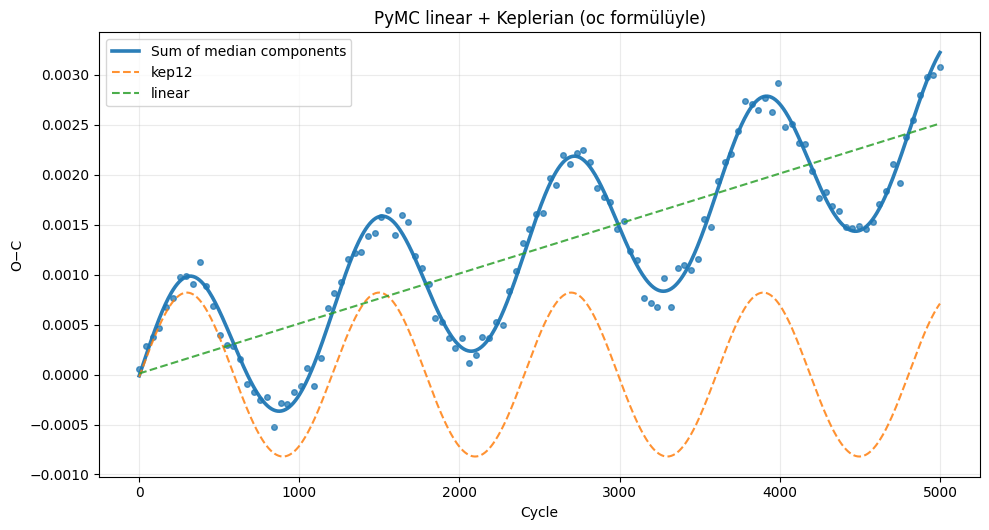

In [7]:
import numpy as np
import matplotlib.pyplot as plt

from ocpy.oc import Linear, Keplerian, Parameter
from ocpy.oc_pymc import OCPyMC

# 1) x ekseni
x6 = np.linspace(0, 5000, 120)

# 2) "gerçek" parametreler
a_true = 5e-7            # lineer eğim
b_true = 0.0

kep_amp   = 8e-4         # keplerian OC genliği
kep_e     = 0.0          # dairesel olsun
kep_omega = 90.0         # derece
kep_P     = 1200.0       # cycle cinsinden
kep_T0    = 300.0        # periastron

# 3) oc'daki Keplerian ile sentetik veri üret
kep_true = Keplerian(
    amp=Parameter(value=kep_amp,   fixed=True),
    e=Parameter(value=kep_e,       fixed=True),
    omega=Parameter(value=kep_omega, fixed=True),
    P=Parameter(value=kep_P,       fixed=True),
    T0=Parameter(value=kep_T0,     fixed=True),
    name="kep1",
)

# lineer + keplerian
y6_true = a_true * x6 + kep_true.model_func(
    x6,
    kep_amp,
    kep_e,
    kep_omega,
    kep_P,
    kep_T0,
)

# gürültü ekle
noise = np.random.normal(0.0, 1e-4, size=x6.size)
y6 = y6_true + noise
err6 = np.full_like(x6, 1e-4)

# 4) PyMC O-C nesnesi
oc6 = OCPyMC(
    oc=y6.tolist(),
    cycle=x6.tolist(),
    minimum_time_error=err6.tolist(),
    minimum_time=[np.nan] * x6.size,
)

# 5) fit edilecek bileşenler (lineer + keplerian)
comp_lin6 = Linear(
    a=Parameter(value=0.0),
    b=Parameter(value=0.0),
)
comp_kep6 = Keplerian(
    amp=Parameter(value=8e-4, min=0.0),
    e=Parameter(value=0.0, min=0.0, max=0.9),
    omega=Parameter(value=90.0),
    P=Parameter(value=1200.0, min=200.0, max=5000.0),
    T0=Parameter(value=300.0),
    name="kep1",
)

idata_mix2 = oc6.fit(
    [comp_lin6, comp_kep6],
    draws=1000,
    tune=1000,
    chains=4,
    target_accept=0.9,
    progressbar=True,
)

oc6.fit_and_report(idata_mix2, title="PyMC linear + Keplerian (oc formülüyle)")